In [36]:
import numpy as np
import pandas as pd

import joblib
import sys

from importlib import reload


from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import MinMaxScaler

import math

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from funciones import multiple_plot
import warnings
warnings.filterwarnings('ignore')

### Cargue del Dataset

In [37]:
d=pd.read_csv('3_Fuel_Consumption_2000-2022_Prep.csv')

In [38]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              14093 non-null  int64  
 1   RANGE_CATEGORY    14093 non-null  object 
 2   VEHICLE CLASS     14093 non-null  object 
 3   ENGINE SIZE       14093 non-null  float64
 4   CYLINDERS         14093 non-null  int64  
 5   FUEL              14093 non-null  object 
 6   FUEL CONSUMPTION  14093 non-null  float64
 7   KMXGALON          14093 non-null  float64
 8   EMISSIONS         14093 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 991.0+ KB


### Datos de entrada

#### Variables categóricas

In [39]:
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()
d[catCols].head()

,RANGE_CATEGORY,VEHICLE CLASS,FUEL
0,MID_RANGE,TRUCK_VAN,O
1,MID_RANGE,TRUCK_VAN,X
2,MID_RANGE,SEDAN_COMPACT,X
3,MID_RANGE,MIDSIZE_FULLSIZE,Z
4,MID_RANGE,TRUCK_VAN,X


#### Variables númericas

In [40]:
numCols=d.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()
d[numCols].head()

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON,EMISSIONS
0,2007,5.3000,8,21.0000,24.1401,298
1,2020,5.3000,8,15.9000,32.1868,326
2,2001,2.0000,4,9.6000,53.1082,198
3,2018,2.3000,4,12.2000,41.8428,252
4,2005,5.6000,8,17.4000,30.5775,345


#### Visualización de variables numéricas con respecto al precio


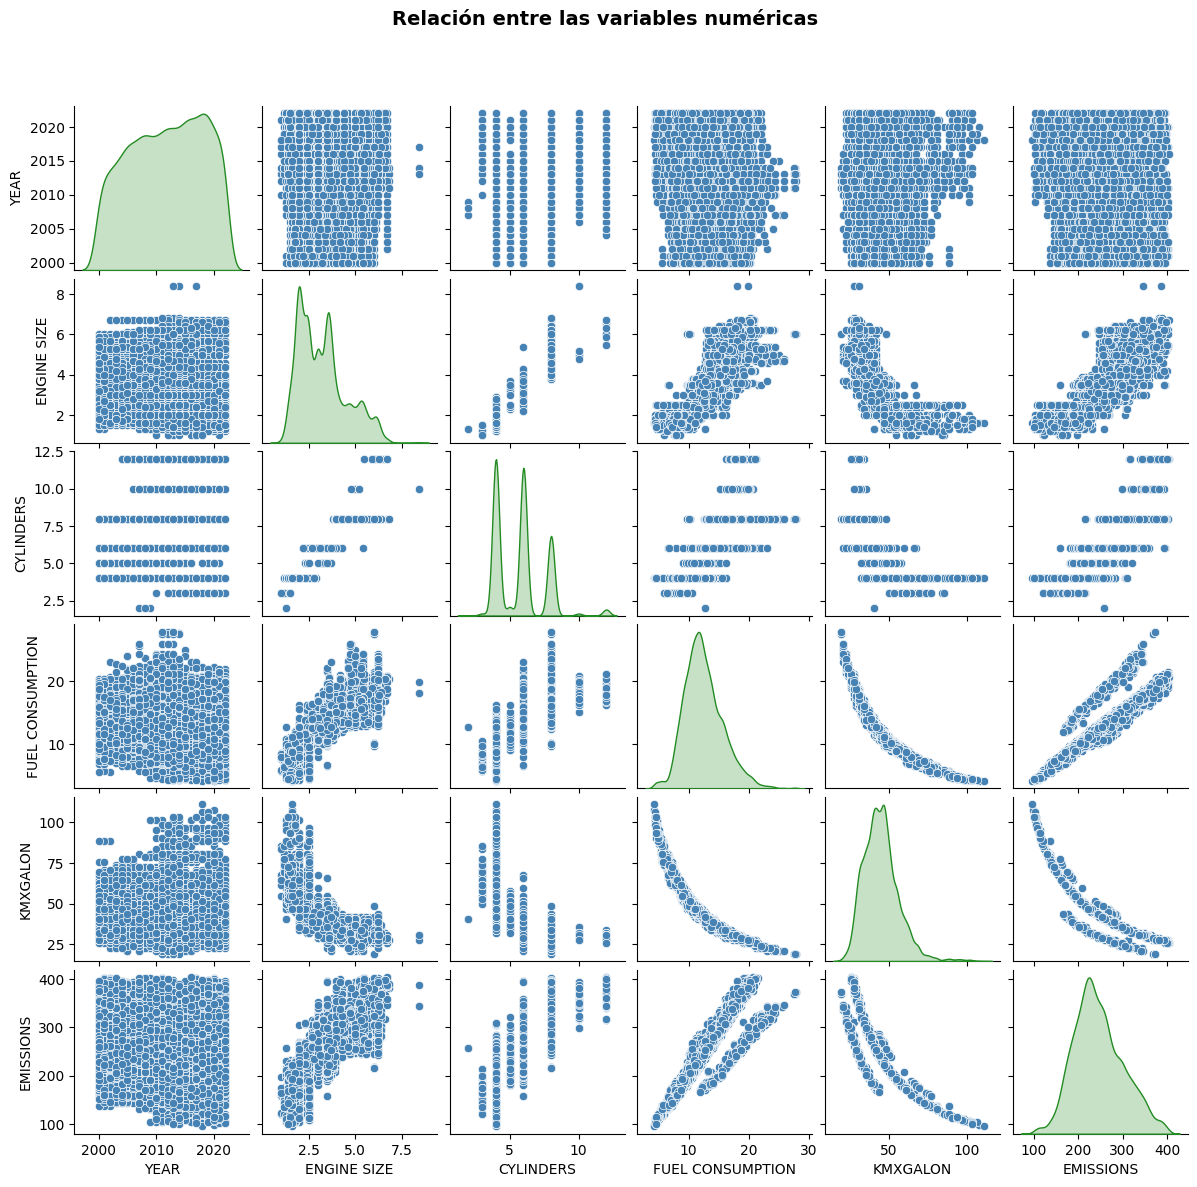

In [41]:
multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [42]:
numCols.remove('EMISSIONS')

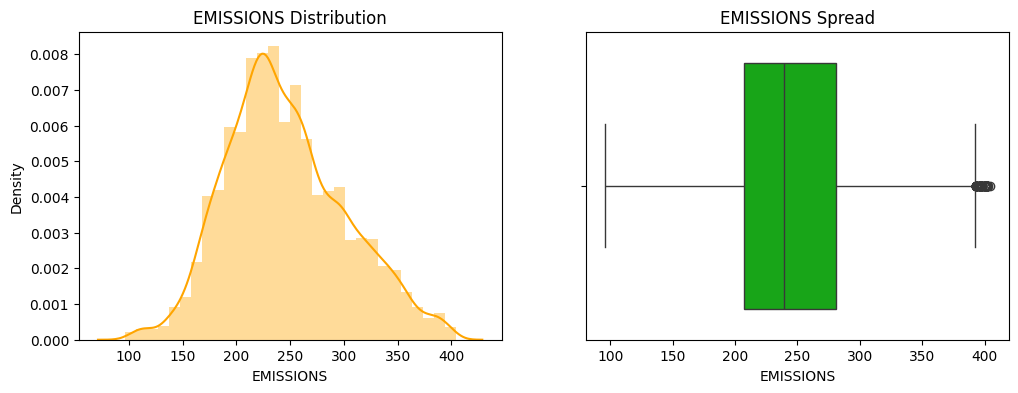

In [43]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('EMISSIONS Distribution')
sns.distplot(d.EMISSIONS, color='orange', bins=30)

plt.subplot(1,2,2)
plt.title('EMISSIONS Spread')
sns.boxplot(x=d.EMISSIONS, palette='nipy_spectral')

plt.show()

In [44]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)

print(d.EMISSIONS.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count   14093
mean      246
std        56
min        96
25%       207
50%       239
75%       281
85%       308
90%       324
95%       347
97.5%     365
100%      404
max       404
Name: EMISSIONS, dtype: float64


### Dumificación de las variables categóricas

In [45]:
d =pd.get_dummies(d, drop_first=1)

In [46]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14093 entries, 0 to 14092
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   YEAR                           14093 non-null  int64  
 1   ENGINE SIZE                    14093 non-null  float64
 2   CYLINDERS                      14093 non-null  int64  
 3   FUEL CONSUMPTION               14093 non-null  float64
 4   KMXGALON                       14093 non-null  float64
 5   EMISSIONS                      14093 non-null  int64  
 6   RANGE_CATEGORY_LOW_RANGE       14093 non-null  bool   
 7   RANGE_CATEGORY_MID_RANGE       14093 non-null  bool   
 8   VEHICLE CLASS_SEDAN_COMPACT    14093 non-null  bool   
 9   VEHICLE CLASS_SUV_CROSSOVER    14093 non-null  bool   
 10  VEHICLE CLASS_TRUCK_VAN        14093 non-null  bool   
 11  VEHICLE CLASS_WAGON_SPECIALTY  14093 non-null  bool   
 12  FUEL_X                         14093 non-null 

### Declaración de las variables X e Y

In [47]:
X = d.drop(columns = "EMISSIONS")
y = d['EMISSIONS']

### División de los datos en train y test


In [48]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [49]:
num_vars = numCols

print(num_vars)

['YEAR', 'ENGINE SIZE', 'CYLINDERS', 'FUEL CONSUMPTION', 'KMXGALON']


### Escalar Variables númericas

In [50]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

scaler = MinMaxScaler()

X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].head(2)

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,KMXGALON
2582,0.5909,0.3649,0.4000,0.3629,0.2281
2320,0.6364,0.3514,0.4000,0.3544,0.2807


### Creación del modelo

In [51]:
modelRF = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'sqrt',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

modelRF.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelRF.predict(X = X_test)

rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

El error (rmse) de test es: 3.5937645561417484
El error (r2) de test es: 0.9956644288080401


In [53]:
X_Completo = X
y_Completo = y

X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

### Guardado del Scaler

In [54]:
joblib.dump(scaler,'scaler/minmaxRandomForest.pkl')

['scaler/minmaxRandomForest.pkl']

### Validación empleando el Out-of-Bag error 


Valor óptimo de n_estimators(árboles): 96


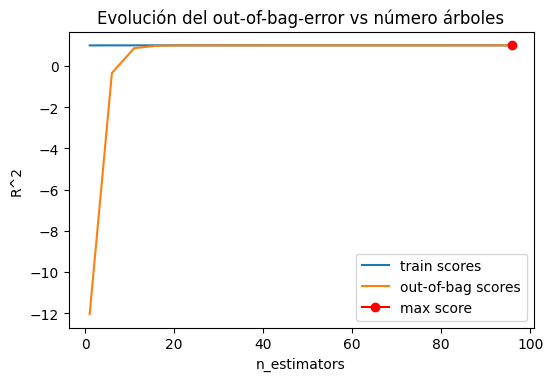

In [55]:
train_scores = []
oob_scores   = []

estimator_range = range(1, 100, 5)


for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)



fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Hace validación cruzada para encontrar el mejor número de arboles.

Su objetivo es encontrar el número óptimo de arboles para minimizar el error de la validacion.

### Validación empleando k-cross-validation y neg_root_mean_squared_error


Valor óptimo de n_estimators: 71


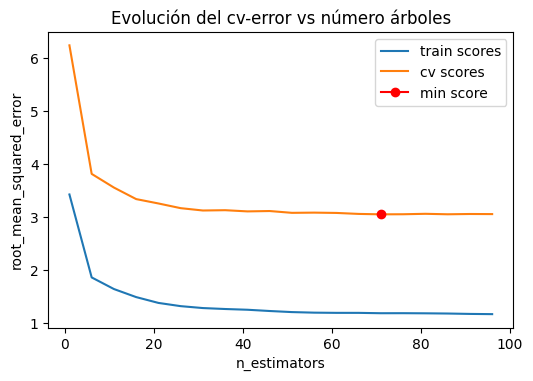

In [56]:
train_scores = []
cv_scores    = []

estimator_range = range(1, 100, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error: mse
                max_depth    = None,
                max_features = 'sqrt',
                oob_score    = False,
                n_jobs       = -1, # se utilizan todos los núcleos disponibles del procesador
                random_state = 123
             )

    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = np.sqrt(mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    cv_scores.append(-1*scores.mean())

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Cada árbol dentro del bosque no usa todas las variables (X) para dividir los nodos.
En cada división, el modelo elige aleatoriamente un subconjunto de características (predictores) para decidir el mejor punto de corte.

Este código busca el número óptimo de variables (max_features) que cada árbol debe considerar para lograr el mejor equilibrio entre ajuste y generalización, midiendo con el error Out-of-Bag (OOB).

### Validación empleando el Out-of-Bag error

Valor óptimo de max_features: 4


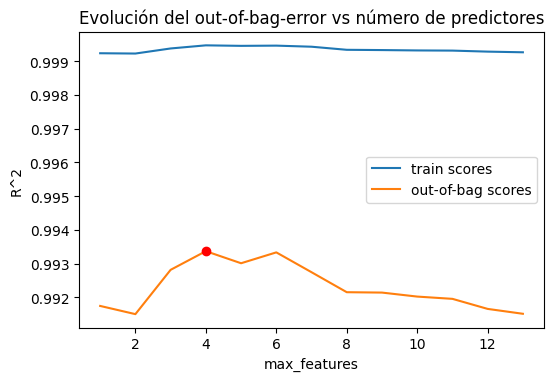

In [57]:
train_scores = []
oob_scores   = []

max_features_range = range(1, X_Completo.shape[1] + 1, 1) 


for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_Completo, y_Completo)
    train_scores.append(modelRF.score(X_Completo, y_Completo))
    oob_scores.append(modelRF.oob_score_)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

### Validación empleando k-cross-validation y neg_root_mean_squared_error

Valor óptimo de max_features: 5


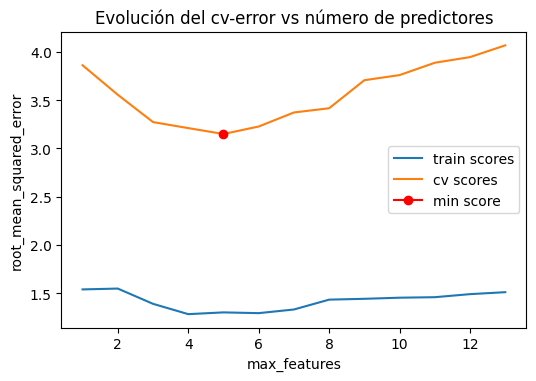

In [58]:
train_scores = []
cv_scores    = []

max_features_range = range(1, X_Completo.shape[1] + 1, 1)

for max_features in max_features_range:

    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelRF.fit(X_Completo, y_Completo)
    predicciones = modelRF.predict(X = X_Completo)
    rmse = np.sqrt(mean_squared_error(
            y_true  = y_Completo,
            y_pred  = predicciones))
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelRF,
                X         = X_Completo,
                y         = y_Completo,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

### Grid de hiperparámetros evaluados

In [59]:
param_grid = ParameterGrid(
                {'n_estimators': [60, 70, 80], # Cantidad de árboles en el bosque
                 'max_features': [4, 5, 7, 8], # Número de características a considerar en cada división
                 'max_depth'   : [4, 8, 12]     # Profundidad máxima del árbol
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelRF = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelRF.fit(X_Completo, y_Completo)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelRF.oob_score_)
    print(f"Modelo: {params} \u2713")

resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(5)

Modelo: {'max_depth': 4, 'max_features': 4, 'n_estimators': 60} ✓
Modelo: {'max_depth': 4, 'max_features': 4, 'n_estimators': 70} ✓
Modelo: {'max_depth': 4, 'max_features': 4, 'n_estimators': 80} ✓
Modelo: {'max_depth': 4, 'max_features': 5, 'n_estimators': 60} ✓
Modelo: {'max_depth': 4, 'max_features': 5, 'n_estimators': 70} ✓
Modelo: {'max_depth': 4, 'max_features': 5, 'n_estimators': 80} ✓
Modelo: {'max_depth': 4, 'max_features': 7, 'n_estimators': 60} ✓
Modelo: {'max_depth': 4, 'max_features': 7, 'n_estimators': 70} ✓
Modelo: {'max_depth': 4, 'max_features': 7, 'n_estimators': 80} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 60} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 70} ✓
Modelo: {'max_depth': 4, 'max_features': 8, 'n_estimators': 80} ✓
Modelo: {'max_depth': 8, 'max_features': 4, 'n_estimators': 60} ✓
Modelo: {'max_depth': 8, 'max_features': 4, 'n_estimators': 70} ✓
Modelo: {'max_depth': 8, 'max_features': 4, 'n_estimators': 80} ✓
Modelo: {'

,oob_r2,max_depth,max_features,n_estimators
31,0.9966,12,7,70
32,0.9966,12,7,80
29,0.9966,12,5,80
30,0.9965,12,7,60
28,0.9965,12,5,70


### Mejores hiperparámetros por out-of-bag error

In [60]:
print("--------------------------------------------")
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,:]['oob_r2'], "R2")

--------------------------------------------
Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
0.9965934822026927 R2


### Entrenameinto del modelo con múltiples hiperparámetros buscando el mejor


In [71]:
# Definir el modelo AdaBoostRegressor
modelRF = RandomForestRegressor(random_state = 123)

CV = 10

parameters =  {'n_estimators': [60, 70, 80], # Cantidad de árboles en el bosque
                 'max_features': [4, 5, 7, 8], # Número de características a considerar en cada división
                 'max_depth'   : [4, 8, 12]     # Profundidad máxima del árbol
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'r2',         #'neg_root_mean_squared_error',
                    n_jobs     = - 1,
                    cv         = CV,
                    refit      = True,
                    verbose    = 3,
                    return_train_score = True
                   )

grid_RF.fit(X = X_Completo, y = y_Completo)


Fitting 10 folds for each of 36 candidates, totalling 360 fits


,estimator,RandomForestR...dom_state=123)
,param_grid,"{'max_depth': [4, 8, ...], 'max_features': [4, 5, ...], 'n_estimators': [60, 70, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,10
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,70


In [72]:
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
28,12,5,70,0.9966,0.0005,0.9985,0.0000
29,12,5,80,0.9966,0.0005,0.9985,0.0000
27,12,5,60,0.9966,0.0005,0.9985,0.0000
26,12,4,80,0.9965,0.0006,0.9983,0.0000


In [73]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Obtener los resultados del grid search
results_grid_RF = pd.DataFrame(grid_RF.cv_results_)

# Seleccionar las columnas deseadas
columns_grid_RF = ['param_max_depth']  + \
                    ['param_max_features']  + \
                    ['param_n_estimators']  + \
                    ['mean_test_score', 'std_test_score']  + \
                    [f'split{i}_test_score' for i in range(CV)]

# Filtrar y mostrar los resultados
results_grid_RF_filtered = results_grid_RF[columns_grid_RF]

# Crear la columna scoreWithStd: f1 / std
results_grid_RF_filtered['scoreWithStd'] = results_grid_RF_filtered.apply(
    lambda row: row['mean_test_score'] / row['std_test_score'] if row['std_test_score'] != 0 else 0,
    axis=1
)

# Encuentra el índice del máximo valor en la columna scoreWithStd
indice_max_scoreWithStd = results_grid_RF_filtered['scoreWithStd'].idxmax()

# Mostrar los scores promedios por cada parámetro
results_grid_RF_filtered[['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
0,4,4,60,0.9276,0.0050,186.5902
1,4,4,70,0.9283,0.0048,192.3392
2,4,4,80,0.9301,0.0049,191.4604
3,4,5,60,0.9397,0.0050,188.3560
4,4,5,70,0.9396,0.0050,186.6183
5,4,5,80,0.9401,0.0049,191.9731
6,4,7,60,0.9455,0.0048,195.3365
7,4,7,70,0.9459,0.0048,196.2858
8,4,7,80,0.9456,0.0049,194.6102
9,4,8,60,0.9472,0.0048,197.0498


In [74]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 12, 'max_features': 5, 'n_estimators': 70}


In [75]:
# Top 3 de los mejores scores
results_grid_RF_filtered.sort_values(by='scoreWithStd', ascending=False).head(3)[
    ['param_max_depth', 'param_max_features','param_n_estimators', 'mean_test_score', 'std_test_score', 'scoreWithStd']]

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,scoreWithStd
28,12,5,70,0.9966,0.0005,1928.2323
29,12,5,80,0.9966,0.0005,1912.2633
27,12,5,60,0.9966,0.0005,1907.7884


In [76]:
# Seleccionar el registro correspondiente al índice máximo
registro_max_scoreWithStd = results_grid_RF_filtered.loc[indice_max_scoreWithStd]

registro_max_scoreWithStd.transpose()

param_max_depth        12.0000
param_max_features      5.0000
param_n_estimators     70.0000
mean_test_score         0.9966
std_test_score          0.0005
split0_test_score       0.9966
split1_test_score       0.9973
split2_test_score       0.9974
split3_test_score       0.9962
split4_test_score       0.9964
split5_test_score       0.9965
split6_test_score       0.9957
split7_test_score       0.9962
split8_test_score       0.9971
split9_test_score       0.9970
scoreWithStd         1928.2323
Name: 28, dtype: float64

In [77]:
results_grid_RF_filtered.loc[indice_max_scoreWithStd]['mean_test_score']

np.float64(0.9966313727938015)

# Creación del modelo con los mejores hiperparámetros

In [78]:
modelRF = RandomForestRegressor( max_depth = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_depth"])
                               , max_features = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_max_features"])
                               , n_estimators = int(results_grid_RF_filtered.loc[indice_max_scoreWithStd]["param_n_estimators"])
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_Completo, y_Completo)

,n_estimators,70
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
importancia_predictores = pd.DataFrame(
                            {'predictor': d.drop(columns = "EMISSIONS").columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
4,KMXGALON,0.4058
3,FUEL CONSUMPTION,0.3168
1,ENGINE SIZE,0.1414
2,CYLINDERS,0.0905
11,FUEL_X,0.0123
0,YEAR,0.0097
12,FUEL_Z,0.0090
9,VEHICLE CLASS_TRUCK_VAN,0.0082
8,VEHICLE CLASS_SUV_CROSSOVER,0.0027
7,VEHICLE CLASS_SEDAN_COMPACT,0.0020


In [80]:
joblib.dump(modelRF,'modelos/RForest_CV.pkl')

['modelos/RForest_CV.pkl']